In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
import random
import itertools
import math
import numpy as np
nx.__version__

import pytsp
import tqdm, sys

import importlib
import logging as log
importlib.reload(log)
log.basicConfig(level=log.INFO, format='LOG %(message)s', stream=sys.stdout)

# import os
# path = '/home/sharik/code/complexity/concorde/build/TSP/concorde'
# os.environ["PATH"] += os.pathsep + path
import subprocess

import matplotlib.colors
rb_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("a", ["black", "blue", "red", "purple"])

from scipy.special import comb

In [2]:
def draw_weighted_graph(G, **kwargs):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, **kwargs)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def draw_12_tsp(G, **kwargs):
    pos = nx.get_node_attributes(G, 'pos')
    edge_color = [0 if G[i][j]['weight'] == 1 else 1 for (i, j) in G.edges]
    width = [0 if G[i][j]['weight'] == 1 else 4 for (i, j) in G.edges]
    alpha = [1 if G[i][j]['weight'] == 1 else 0.5 for (i, j) in G.edges]
    nx.draw(G, pos, with_labels=True,  \
            edge_color=edge_color, width=width, edge_cmap=rb_cmap, **kwargs)
    
    labels = dict([(edge, 2) for (edge, i) in nx.get_edge_attributes(G,'weight').items() if i == 2])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def choose_color(edge, A, C):
    if edge in A.edges and edge in C.edges:
        return 3
    elif edge in A.edges:
        return 1
    elif edge in C.edges:
        return 2
    else:
        return 0

In [3]:
def weight_of_path(G, path):
    s = 0
    try:
        for i in range(0, len(path)-1):
            u = list(G.nodes())[path[i]]
            v = list(G.nodes())[path[i+1]]
            s += G[u][v]['weight']
    except KeyError:
        return math.inf
    return s

def weight_of_cycle(G, path):
    return weight_of_path(G, path) + G[list(G.nodes)[path[0]]][list(G.nodes)[path[-1]]]['weight']

In [4]:
def solve_with_concorde(G):
    """Обращение к библиотеке Concorde."""
    matrix = nx.to_numpy_matrix(G, weight='weight').A
    for i in range(0, matrix.shape[0]):
        for j in range(0, i):#matrix.shape[1]):
            if matrix[i][j] == 0:
                matrix[i][j] = 32768
    #print(matrix)
    matrix_sym = pytsp.atsp_tsp(matrix, strategy="cutoff")
    outf = "./myroute.tsp"
    with open(outf, 'w') as dest:
        dest.write(pytsp.dumps_matrix(matrix_sym, name="My Route"))

    #tour = pytsp.run(outf, start=0, solver="concorde")
    #print(subprocess.call(["/home/sharik/code/complexity/concorde/build/TSP/concorde", outf]))
    response = subprocess.call(["/home/sharik/build/concorde/TSP/concorde", outf])
    
    inf = './myroute.sol'
    path = []
    with open(inf, 'r') as src:
        n = int(src.readline())
        lines = src.readlines()
        for line in lines:
            path += [int(x) for x in line.split(' ')[:-1]]
    return n, path

In [5]:
def check_if_matching(G, k):
    """Проверка, является ли граф G k-паросочетанием"""
    for n in G.nodes:
        if len(list(G.neighbors(n))) > k:
            return False
    return True

def get_components_count(G):
    """Подсчёт по графу G всех необходимых значений: 
    количество путей и циклов, объединением которых он является,
    количество вершин в циклах и
    количество синглтонов"""
    subgraphs = nx.connected_component_subgraphs(G)
    number_vertices_in_cycles = 0
    components_count = 0
    singletons_count = 0
    for g in subgraphs:
        components_count += 1
        if g.number_of_nodes() == 2 and g.number_of_edges() == 1:
            singletons_count += 1
        try:
            if len(nx.find_cycle(g)) == len(g.nodes):
                number_vertices_in_cycles += len(G.nodes)
        except nx.NetworkXNoCycle:
            pass
    return components_count, number_vertices_in_cycles, singletons_count

def get_chain_on_nodes(G, C_nodes):
    """Возвращает граф, который есть цепь из G на данных C_nodes вершинах"""
    return set([(C_nodes[i], C_nodes[i+1]) 
                for i in range(0, len(C_nodes)-1) 
                if (C_nodes[i], C_nodes[i+1]) in G.edges])

In [6]:
def improv(K, G, draw=False, simple=False):
    """Алгоритм K-IMPROV"""
    if simple:
        if K > G.number_of_edges():
            K = G.number_of_edges()
    else:
        if K>G.number_of_nodes():
            K = G.number_of_nodes()
            
    # Изначально A пусто
    A = nx.Graph()
    A.add_nodes_from(G.nodes)
    A_components_num = sys.maxsize
    A_vertices_in_cycles_num = sys.maxsize
    A_singletons_num = sys.maxsize
    
    # Перебираем все возможные варианты для C
    log.info('Граф с %d вершинами и %d рёбрами'%(G.number_of_nodes(), G.number_of_edges()))
    if simple:
        max_iter = sum([comb(G.number_of_edges(), i) for i in range(0, K+1)])-G.number_of_edges()-1
    else:
        max_iter = sum([comb(G.number_of_nodes(), i) for i in range(0, K+1)])-G.number_of_nodes()-1
    log.info('Число комбинаций для перебора %d при K=%d'%(max_iter, K))
    
    n_global_iter = 0
    something_changes = True
    last_modification_iter, last_modification_global_iter = 0, 1
    while something_changes:
        n_global_iter += 1
        log.info('             GLOBAL ITERATION %d'%n_global_iter)
        something_changes = False
        if simple:
            C_edges_s = itertools.chain.from_iterable(itertools.combinations(G.edges, i) 
                                                      for i in range(1, K+1))
        else:
            C_nodes_s = itertools.chain.from_iterable(itertools.combinations(G.nodes, i) 
                                                      for i in range(2, K+1))
            C_edges_s = map(lambda C_nodes: get_chain_on_nodes(G, C_nodes),C_nodes_s)
        
        pbar = tqdm.tqdm_notebook(total=max_iter)
        for n_iter, C_edges in enumerate(C_edges_s):
            pbar.update(1)
            
            if last_modification_global_iter < n_global_iter and n_iter > last_modification_iter:
                log.info("Early exit: nothing to check")
                break
            if C_edges == set():
                continue
            
            C = nx.Graph()
            C.add_nodes_from(G.nodes)
            C.add_edges_from(C_edges)
            G_new = nx.symmetric_difference(A, C)

            cur_components_num, cur_vertices_in_cycles_num, cur_singletons_num = get_components_count(G_new)

            if check_if_matching(G_new, 2):
                if (cur_components_num<A_components_num) \
                        or (cur_components_num == A_components_num \
                            and cur_vertices_in_cycles_num > A_vertices_in_cycles_num) \
                        or (cur_components_num == A_components_num \
                            and cur_vertices_in_cycles_num == A_vertices_in_cycles_num \
                            and cur_singletons_num < A_singletons_num):
                    something_changes = True
                    log.info('Changing A: %d %d %d'%( cur_components_num, cur_vertices_in_cycles_num, cur_singletons_num))
                    log.debug('was: %d %d %d'%( A_components_num, A_vertices_in_cycles_num, A_singletons_num))
                    last_modification_iter = n_iter
                    last_modification_global_iter = n_global_iter

                    # Баг networkx: если вставить рисовалку сюда, первый раз будет неправильный цвет.
    
                    A = G_new
                    A_components_num = cur_components_num
                    A_vertices_in_cycles_num = cur_vertices_in_cycles_num
                    A_singletons_num = cur_singletons_num

                    if draw:
                        edge_color = [choose_color(edge, A, C) for edge in G.edges ]
                        plt.figure(figsize=(5,5))
                        draw_weighted_graph(G, edge_color=edge_color, width=4, edge_cmap=rb_cmap)
                        plt.show()
        pbar.close()

    algo_ans = G.number_of_nodes()+A_components_num
    nx.draw(A, with_labels=True)
    return algo_ans

In [7]:
def get_G(nodes, edges):
    """Строит граф с данными вершинами и рёбрами (на вход можно подавать только рёбра только веса 1)"""
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    for u, v in G.edges():
        G[u][v]['weight'] = 1
    return G

def process_tsp_manual(G, **kwargs):
    """Вспомогательная функция. 
    G: граф, в котором вершины имеют pos, рёбра имеют weight=1
    Граф конвертируется в экземпляр (1,2)-TSP 
    (в нём проводятся рёбра длины 2, остальные рёбра считаются +inf).
    Далее запускаются решатель Concorde и наш алгоритм, и сравнивается ответ."""
    #draw_weighted_graph(G)
    
    G_ = G.copy()
    for i in G_.nodes():
        for j in G_.nodes():
            if i != j and not G_.has_edge(i, j):
                G_.add_edge(i, j, weight=2)
    
    #draw_12_tsp(G_)
    n, path = solve_with_concorde(G_)
    print('Concorde path', path)
    concorde_ans = weight_of_cycle(G_, path)
    print('Concorde answer', concorde_ans)
    
    algo_ans = improv(15, G, **kwargs)
    print('Algorithm answer', algo_ans)
    
    if concorde_ans*8/7<algo_ans:
        print("ALGORITHM FAILED")
        return False
    elif concorde_ans > algo_ans:
        print("SOMETHING WRONG: algorithm is better than Concorde")
        return False
    else:
        print("ALGORITHM SUCCEEDED")
        return True

Concorde path [0, 6, 3, 4, 5, 2, 1]
Concorde answer 8
LOG Граф с 7 вершинами и 8 рёбрами
LOG Число комбинаций для перебора 120 при K=7
LOG              GLOBAL ITERATION 1


HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

LOG Changing A: 6 0 1
LOG Changing A: 5 0 0
LOG Changing A: 4 0 0
LOG Changing A: 3 0 0
LOG Changing A: 2 0 0
LOG Changing A: 1 0 0

LOG              GLOBAL ITERATION 2


HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

LOG Early exit: nothing to check

Algorithm answer 8
ALGORITHM SUCCEEDED


True

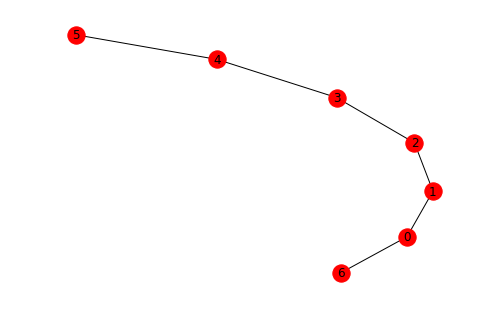

In [8]:
G = get_G(
    [[0, {'pos':(0,0)}],
     [1, {'pos':(1,0)}],
     [2, {'pos':(1,1)}],
     [3, {'pos':(1,2)}],
     [4, {'pos':(2,2)}],
     [5, {'pos':(2,1)}],
     [6, {'pos':(0,1)}]],
    [[2, 6], [6, 0], [0, 1], [1,2], [2, 3], [3, 4], [4, 5], [5, 2]])

# import dot2tex as d2t
# dot_object = nx.drawing.nx_pydot.to_pydot(G)
# texcode = d2t.dot2tex(dot_object.to_string(), format='tikz', crop=True)

process_tsp_manual(G, draw=False)

Concorde path [0, 6, 4, 5, 7, 2, 3, 1]
Concorde answer 10
LOG Граф с 8 вершинами и 8 рёбрами
LOG Число комбинаций для перебора 247 при K=8
LOG              GLOBAL ITERATION 1


HBox(children=(IntProgress(value=0, max=247), HTML(value='')))

LOG Changing A: 7 0 1
LOG Changing A: 6 0 0
LOG Changing A: 5 0 0
LOG Changing A: 5 8 0
LOG Changing A: 4 8 1
LOG Changing A: 3 8 0
LOG Changing A: 2 8 0
LOG Changing A: 2 16 0

LOG              GLOBAL ITERATION 2


HBox(children=(IntProgress(value=0, max=247), HTML(value='')))

LOG Early exit: nothing to check

Algorithm answer 10
ALGORITHM SUCCEEDED


True

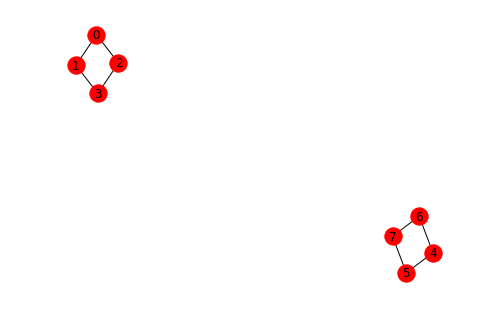

In [9]:
process_tsp_manual(get_G(
    [[0, {'pos':(0,0)}],
     [1, {'pos':(1,0)}],
     [2, {'pos':(0,1)}],
     [3, {'pos':(1,1)}],
     [4, {'pos':(3,0)}],
     [5, {'pos':(4,0)}],
     [6, {'pos':(3,1)}],
     [7, {'pos':(4,1)}]],
    [[0, 1], [1, 3], [3, 2], [2,0], [6, 7], [7, 5], [5, 4], [4, 6]]),
                  draw=False, simple=False)


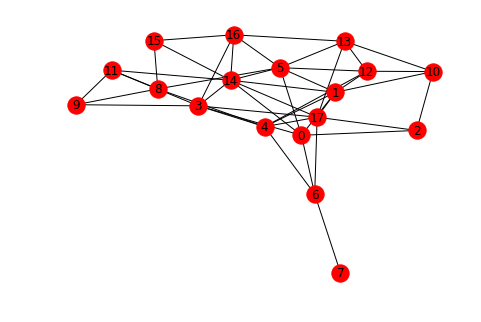

Concorde path [0, 7, 6, 17, 2, 10, 13, 16, 15, 8, 11, 9, 3, 4, 12, 5, 14, 1]
Concorde answer 19
LOG Граф с 18 вершинами и 45 рёбрами
LOG Число комбинаций для перебора 261953 при K=15
LOG              GLOBAL ITERATION 1


HBox(children=(IntProgress(value=0, max=261953), HTML(value='')))

LOG Changing A: 17 0 1
LOG Changing A: 16 0 0
LOG Changing A: 15 0 0
LOG Changing A: 14 0 0
LOG Changing A: 13 0 0
LOG Changing A: 12 0 0
LOG Changing A: 11 0 1
LOG Changing A: 10 0 0
LOG Changing A: 9 0 1
LOG Changing A: 8 0 0
LOG Changing A: 7 0 0
LOG Changing A: 7 18 0
LOG Changing A: 6 18 1
LOG Changing A: 5 18 2
LOG Changing A: 4 18 1
LOG Changing A: 3 18 0
LOG Changing A: 2 18 0
LOG Changing A: 1 0 0

LOG              GLOBAL ITERATION 2


HBox(children=(IntProgress(value=0, max=261953), HTML(value='')))

LOG Early exit: nothing to check

Algorithm answer 19
ALGORITHM SUCCEEDED


True

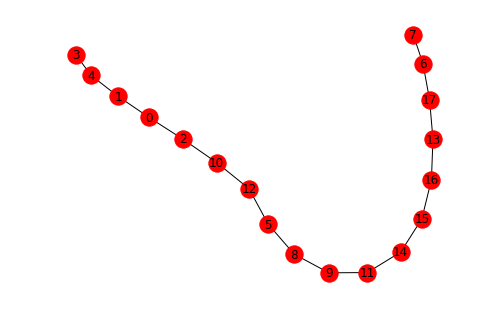

In [10]:
def set_edges_weight(G, w):
    for u, v in G.edges():
        G[u][v]['weight'] = w
    return G

def gen_random_graph(n, p=None, m=None):
    if p is None and m is None or not (p is None or m is None):
        raise Exception("Wrong params")
        
    if p is not None:
        G = nx.random_graphs.gnp_random_graph(n, p)
    else:
        G = nx.random_graphs.gnm_random_graph(n, m)
    nx.draw(G, with_labels=True)
    plt.show()
    G = set_edges_weight(G, 1)
    return G

G = gen_random_graph(18, m=45)
process_tsp_manual(G)